# KNN Model:
* GOAL: create an optimized KNN model for classifying how many wins a team will get in the tournament by clustering to similar teams

In [50]:
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier

df = pl.read_csv('../input_data/model_data.csv')
print(df.shape)
display(df.head())

(748, 21)


G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,POSTSEASON_WINS
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1,5
40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1,5
40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,3,5
38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,3,5
39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,1,5


### Feature scaling:
* Note - we split first because to apply this model, we shouldn't be learning on any of the test data because we won't have that information for new results

In [3]:
x = df.select(pl.all().exclude('POSTSEASON_WINS'))
y = df.select('POSTSEASON_WINS')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=84305)

## feature scaling as we have many different values - important to do after the test train split
scaler = StandardScaler()

## use fit transform for training to learn the transformations and just transform for the rest
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### Principal component analysis
* We will use this to reduce the dimensionality of our data as we currently have quite a few variables

In [ ]:
## we can set the value to .8 so we ensure we are explaining 80% of the variance
pca = PCA(.8)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
print('We will be using this many components:', pca.n_components_)

We will be using this many components: 8


## Create a bunch of models to find the optimal value of k
* This is called the elbow method

c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

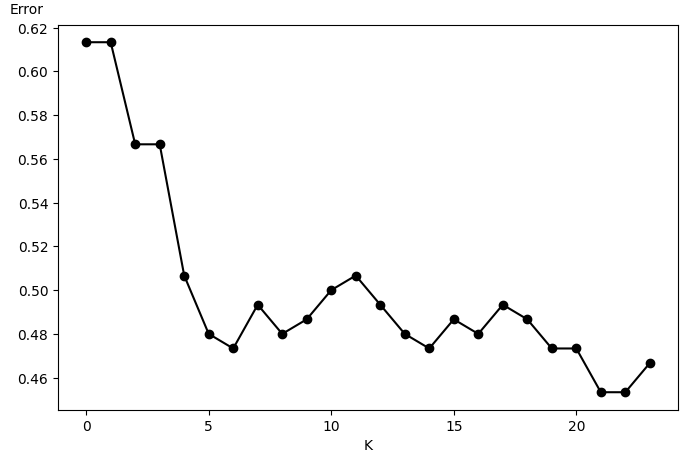

In [ ]:
## using 10 fold cross validation error to find optimal K

errors = []
for i in range (1, 25):
      knn = KNeighborsClassifier(n_neighbors=i, weights = 'distance')
      score = cross_val_score(knn, x_test_pca, y_test, cv=10)
      errors.append(1-score.mean())


fig, ax = plt.subplots(figsize = (8,5))
plt.plot(errors, color = 'black', marker = 'o')
plt.xlabel('K')
plt.ylabel('Error', rotation = 0)
ax.yaxis.set_label_coords(-0.05,1.02)

### Bagging:
* Our optimal K appears to be about 5 so we can use that going forward as we use bagging to improve the results
* this is an ensemble method to average the predictions and potentially better reprsent all classes


In [27]:
knn_5 = KNeighborsClassifier(n_neighbors=5, weights = 'distance')

In [ ]:
bagging_knn = BaggingClassifier(
    estimator=knn_5, ## our optimized KNN classifier
    n_estimators=100, ## we want a lot of classifiers because we don't have a lot of data
    random_state=85794, ## a random random state
    bootstrap=True,  ## Sample with replacement
    max_samples=1.0, ## .9 * size of x (aka 90% of samples)
    bootstrap_features=True ## replacement is allowed
)

## Get a cross fold validation look at how well the model performed

In [48]:
bagging_knn.fit(x_train_pca, y_train)
y_pred = bagging_knn.predict(x_test_pca)
cross_val_score(bagging_knn, x_test_pca, y_test, cv=10)

c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\ensemble\_bagging.py:930: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\ensemble\_bagging.py:930: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\ensemble\_bagging.py:930: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

array([0.6       , 0.73333333, 0.53333333, 0.46666667, 0.53333333,
       0.53333333, 0.46666667, 0.6       , 0.53333333, 0.46666667])

In [43]:
# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.5533333333333333


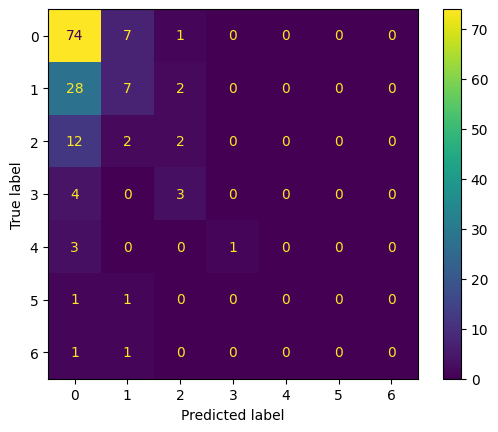

In [45]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=bagging_knn.classes_).plot()

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.90      0.72        82
           1       0.39      0.19      0.25        37
           2       0.25      0.12      0.17        16
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2

    accuracy                           0.55       150
   macro avg       0.18      0.17      0.16       150
weighted avg       0.45      0.55      0.48       150



c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ralgi\dev\basketball_bracket\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

# SUMMARY:

* KNN is probably just not a good choice for this data. The clusters are unevenly distributed and the model just guesses 0/1 wins all the time to get a decent but unhelpful accuracy even with PCA and boosting methods. Other methods are likely to do better so I won't spend too much time trying to improve these results.
* Looking at the confusion matrix, there is only 1 value for both 5 and 6 win teams. It's going to be basically impossible to predict those with KNN as there isn't enough data to form a cluster